In [96]:
import pandas as pd
import scanpy as sc
import anndata
import xarray as xr
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import pathlib
import numpy as np
import seaborn as sns
from ALLCools.clustering import significant_pc_test
from matplotlib import pyplot as plt

In [97]:
metadata_path = '~/CellMetadata.324687.2021-09-13.hdf'
mapping_rate_cutoff=0.5
mapping_rate_col_name='MappingRate'  # Name may change
final_reads_cutoff=500000
final_reads_col_name='FinalReads'  # Name may change
mccc_cutoff=0.03
mccc_col_name='mCCCFrac'  # Name may change
mch_cutoff=0.2
mch_col_name='mCHFrac'  # Name may change
mcg_cutoff=0.5
mcg_col_name='mCGFrac'  # Name may change

In [98]:
metadata = pd.read_hdf(metadata_path, index_col=0)
metadata = metadata[metadata.Sample.str.startswith('8')] # added this line for integration with MERFISH
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 31726 cells


In [99]:
metadata

,AllcPath,mCCCFrac,mCGFrac,mCGFracAdj,mCHFrac,mCHFracAdj,FinalReads,InputReads,MappedReads,DissectionRegion,BamFilteringRate,MappingRate,Plate,Col384,Row384,FANSDate,Slice,Sample
8A_M_0,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.006923,0.772470,0.770884,0.031925,0.025177,1455040.0,3349214,2267861.0,8A,0.641591,0.677132,CEMBA191107-8A-1,0,0,191107,8,8A_191107
8A_M_1,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.005836,0.757967,0.756546,0.022677,0.016939,1728428.0,4023480,2744815.0,8A,0.629707,0.682199,CEMBA191107-8A-1,0,1,191107,8,8A_191107
8A_M_10,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.005438,0.766792,0.765517,0.018819,0.013454,3046368.0,6490594,4463587.0,8A,0.682493,0.687701,CEMBA191107-8A-1,19,0,191107,8,8A_191107
8A_M_100,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.007632,0.800078,0.798541,0.038919,0.031528,1941026.0,4608022,3118870.0,8A,0.622349,0.676835,CEMBA191107-8A-2,0,2,191107,8,8A_191107
8A_M_1000,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.006732,0.780300,0.778811,0.033268,0.026715,1217213.0,2714186,1865989.0,8A,0.652315,0.687495,CEMBA191107-8A-4,5,4,191107,8,8A_191107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8G_M_3052,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.011492,0.848714,0.846956,0.054563,0.043572,960613.0,3420758,2284908.0,8G,0.420416,0.668831,CEMBA201105_8G_3,7,14,201105,8,8G_201105
8G_M_3053,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.012451,0.798422,0.795881,0.051265,0.039303,1139559.0,3968700,2674134.0,8G,0.426141,0.674741,CEMBA201105_8G_3,18,15,201105,8,8G_201105
8G_M_3054,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.010043,0.829363,0.827632,0.041210,0.031483,808639.0,2660852,1826753.0,8G,0.442665,0.687759,CEMBA201105_8G_3,19,15,201105,8,8G_201105
8G_M_3055,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.011201,0.816029,0.813945,0.050785,0.040032,859906.0,2911520,1956885.0,8G,0.439426,0.673350,CEMBA201105_8G_3,6,15,201105,8,8G_201105


# Filter by key mapping metrics

## Bimark Mapping Rate

31590 / 31726 cells (99.6%) passed the MappingRate cutoff 0.5.


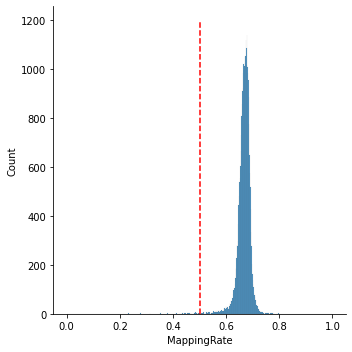

In [100]:
_cutoff = mapping_rate_cutoff
_col_name = mapping_rate_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mapping_rate_judge = metadata[_col_name] > _cutoff
_passed_cells = mapping_rate_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

## Final Reads

30323 / 31726 cells (95.6%) passed the FinalReads cutoff 500000.


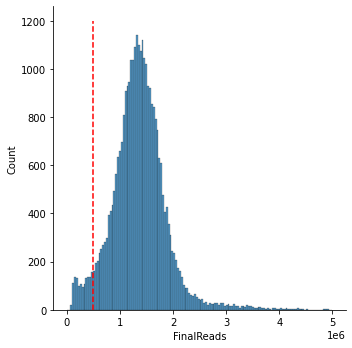

In [101]:
_cutoff = final_reads_cutoff
_col_name = final_reads_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 5e6))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

final_reads_judge = metadata[_col_name] > _cutoff
_passed_cells = final_reads_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

In [102]:
final_reads_judge.sum()

30323

## mCCC / CCC

31724 / 31726 cells (100.0%) passed the mCCCFrac cutoff 0.03.


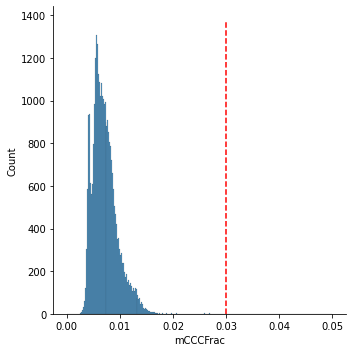

In [103]:
_cutoff = mccc_cutoff
_col_name = mccc_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 0.05))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mccc_judge = metadata[_col_name] < _cutoff
_passed_cells = mccc_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

## mCH / CH

31726 / 31726 cells (100.0%) passed the mCHFrac cutoff 0.2.


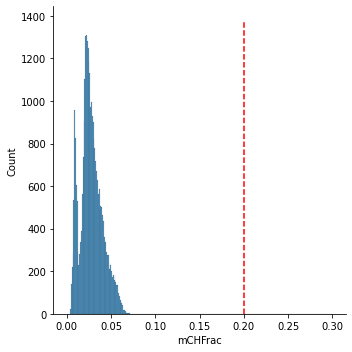

In [104]:
_cutoff = mch_cutoff
_col_name = mch_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 0.3))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mch_judge = metadata[_col_name] < _cutoff
_passed_cells = mch_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

## mCG

31726 / 31726 cells (100.0%) passed the mCGFrac cutoff 0.5.


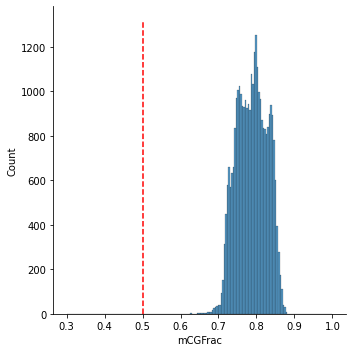

In [105]:
_cutoff = mcg_cutoff
_col_name = mcg_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0.3, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mcg_judge = metadata[_col_name] > _cutoff
_passed_cells = mcg_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

## Combine filters

In [106]:
judge = mapping_rate_judge & final_reads_judge & mccc_judge & mch_judge & mcg_judge
passed_cells = judge.sum()
print(
    f'{passed_cells} / {total_cells} cells ({passed_cells / total_cells * 100:.1f}%) '
    f'passed all the filters.')

30253 / 31726 cells (95.4%) passed all the filters.


In [107]:
try:
    assert (passed_cells / total_cells) > 0.6
except AssertionError as e:
    e.args += (
        'A large amount of the cells do not pass filter, check your cutoffs or overall dataset quality.',
    )
    raise e

try:
    assert passed_cells > 0
except AssertionError as e:
    e.args += ('No cell remained after all the filters.', )
    raise e

print('Feel good')

Feel good


In [108]:
metadata_filtered = metadata[judge].copy()

In [109]:
metadata_filtered

,AllcPath,mCCCFrac,mCGFrac,mCGFracAdj,mCHFrac,mCHFracAdj,FinalReads,InputReads,MappedReads,DissectionRegion,BamFilteringRate,MappingRate,Plate,Col384,Row384,FANSDate,Slice,Sample
8A_M_0,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.006923,0.772470,0.770884,0.031925,0.025177,1455040.0,3349214,2267861.0,8A,0.641591,0.677132,CEMBA191107-8A-1,0,0,191107,8,8A_191107
8A_M_1,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.005836,0.757967,0.756546,0.022677,0.016939,1728428.0,4023480,2744815.0,8A,0.629707,0.682199,CEMBA191107-8A-1,0,1,191107,8,8A_191107
8A_M_10,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.005438,0.766792,0.765517,0.018819,0.013454,3046368.0,6490594,4463587.0,8A,0.682493,0.687701,CEMBA191107-8A-1,19,0,191107,8,8A_191107
8A_M_100,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.007632,0.800078,0.798541,0.038919,0.031528,1941026.0,4608022,3118870.0,8A,0.622349,0.676835,CEMBA191107-8A-2,0,2,191107,8,8A_191107
8A_M_1000,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8A/CEMBA...,0.006732,0.780300,0.778811,0.033268,0.026715,1217213.0,2714186,1865989.0,8A,0.652315,0.687495,CEMBA191107-8A-4,5,4,191107,8,8A_191107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8G_M_3052,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.011492,0.848714,0.846956,0.054563,0.043572,960613.0,3420758,2284908.0,8G,0.420416,0.668831,CEMBA201105_8G_3,7,14,201105,8,8G_201105
8G_M_3053,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.012451,0.798422,0.795881,0.051265,0.039303,1139559.0,3968700,2674134.0,8G,0.426141,0.674741,CEMBA201105_8G_3,18,15,201105,8,8G_201105
8G_M_3054,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.010043,0.829363,0.827632,0.041210,0.031483,808639.0,2660852,1826753.0,8G,0.442665,0.687759,CEMBA201105_8G_3,19,15,201105,8,8G_201105
8G_M_3055,/gale/ddn/cemba/CEMBA/Mouse/CEMBA_RS1/8G/CEMBA...,0.011201,0.816029,0.813945,0.050785,0.040032,859906.0,2911520,1956885.0,8G,0.439426,0.673350,CEMBA201105_8G_3,6,15,201105,8,8G_201105


# Basic Feature Filtering

In [110]:
gene_meta_path = '~/gencode.vM22.annotation.gene.flat.tsv.gz'
mcds_paths = '~/dataset/snmC/mcds/*mcds'
obs_dim = 'cell'  # observation
var_dim = 'geneslop2k'  # feature

min_cov = 5

black_list_path = '~/ref/blacklist/mm10-blacklist.v2.bed.gz'
f = 0.2

exclude_chromosome = ['chrM']

In [111]:
gene_meta=pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')

In [112]:
gene_meta

,chrom,source,feature,start,end,score,strand,phase,transcript_id,gene_type,...,gene_name,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,chr1,HAVANA,gene,3073253,3074322,.,+,.,NaN,TEC,...,4933401J01Rik,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
ENSMUSG00000064842.1,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,NaN,snRNA,...,Gm26206,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
ENSMUSG00000051951.5,chr1,HAVANA,gene,3205901,3671498,.,-,.,NaN,protein_coding,...,Xkr4,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
ENSMUSG00000102851.1,chr1,HAVANA,gene,3252757,3253236,.,+,.,NaN,processed_pseudogene,...,Gm18956,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
ENSMUSG00000103377.1,chr1,HAVANA,gene,3365731,3368549,.,-,.,NaN,TEC,...,Gm37180,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064368.1,chrM,ENSEMBL,gene,13552,14070,.,-,.,NaN,protein_coding,...,mt-Nd6,NaN,NaN,NaN,NaN,NaN,3,MGI:102495,NaN,NaN
ENSMUSG00000064369.1,chrM,ENSEMBL,gene,14071,14139,.,-,.,NaN,Mt_tRNA,...,mt-Te,NaN,NaN,NaN,NaN,NaN,3,MGI:102488,NaN,NaN
ENSMUSG00000064370.1,chrM,ENSEMBL,gene,14145,15288,.,+,.,NaN,protein_coding,...,mt-Cytb,NaN,NaN,NaN,NaN,NaN,3,MGI:102501,NaN,NaN


## Filter genes by overlap and chromosomes

In [113]:
genes_to_skip = set()

gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

In [114]:
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(exclude_chromosome)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

41871 features remained


## Filter genes by cell mean coverage

Open MCDS with netcdf4 engine.
Feature geneslop2k mean cov across cells added in MCDS.coords['geneslop2k_cov_mean'].


/tmp/ipykernel_201190/232139038.py:8: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  use_features &= feature_cov_mean[feature_cov_mean > min_cov].index


40262 features remained


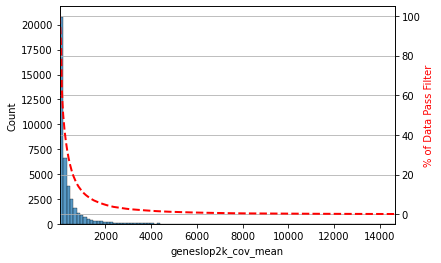

In [115]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # still use all the cells to load MCDS
    mcds = MCDS.open(mcds_paths, obs_dim=obs_dim,
                     use_obs=metadata.index).sel({var_dim: use_features})
mcds.add_feature_cov_mean(var_dim=var_dim)

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

In [116]:
mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)


Before cov mean filter: 41871 geneslop2k
 After cov mean filter: 40262 geneslop2k 96.2%


<xarray.MCDS>
Dimensions:              (mc_type: 2, cell: 31726, count_type: 2, chrom100k: 27269, geneslop2k: 40262)
Coordinates: (12/13)
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * cell                 (cell) object '8A_M_1001' '8A_M_1000' ... '8L_M_3064'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<chunksize=(27269,), meta=np.ndarray>
    ...                   ...
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(27269,), meta=np.ndarray>
  * geneslop2k           (geneslop2k) object 'ENSMUSG00000102693.1' ... 'ENSM...
    geneslop2k_chrom     (geneslop2k) object dask.array<chunksize=(40262,), meta=np.ndarray>
    geneslop2k_start     (geneslop2k) int64 dask.array<chunksize=(40262,), meta=np.ndarray>
    geneslop2k_end       (geneslop2k) int64 dask.array<chunksize=(40262,), meta=np.ndarray>
    geneslop2k_cov_mean  (geneslop2k) float64 65.33 52.01 ... 37.76 1.285e+03
Data variables:
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint16 dask.array<chunksize=(500, 27269, 1, 2), meta=np.ndarray>
    geneslop2k_da        (cell, geneslop2k, mc_type, count_type) uint32 dask.array<chunksize=(150, 40262, 1, 2), meta=np.ndarray>

## Add gene mC fraction 

In [117]:
total_mcds = mcds.sel({var_dim: use_features})
total_mcds.add_mc_rate(var_dim=var_dim, normalize_per_cell=True, clip_norm_value=10)
# total_mcds = total_mcds.rename({var_dim: 'gene', f'{var_dim}_da_frac': 'gene_da_frac'})

/home/jiaying/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [118]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta

,chrom,source,feature,start,end,score,strand,phase,transcript_id,gene_type,...,gene_name,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
ENSMUSG00000102693.1,chr1,HAVANA,gene,3073253,3074322,.,+,.,NaN,TEC,...,4933401J01Rik,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
ENSMUSG00000064842.1,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,NaN,snRNA,...,Gm26206,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
ENSMUSG00000051951.5,chr1,HAVANA,gene,3205901,3671498,.,-,.,NaN,protein_coding,...,Xkr4,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
ENSMUSG00000102348.1,chr1,HAVANA,gene,3680155,3681788,.,+,.,NaN,TEC,...,Gm10568,NaN,NaN,NaN,NaN,NaN,2,MGI:3642703,OTTMUSG00000049922.1,NaN
ENSMUSG00000102592.1,chr1,HAVANA,gene,3752010,3754360,.,+,.,NaN,TEC,...,Gm38385,NaN,NaN,NaN,NaN,NaN,2,MGI:5611613,OTTMUSG00000049923.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100246.1,chrY,HAVANA,gene,89999717,90000411,.,+,.,NaN,unprocessed_pseudogene,...,Gm20879,NaN,NaN,NaN,NaN,NaN,1,MGI:5434235,OTTMUSG00000047350.1,pseudo_consens
ENSMUSG00000096178.7,chrY,HAVANA,gene,90401248,90433263,.,+,.,NaN,protein_coding,...,Gm20837,NaN,NaN,NaN,NaN,NaN,2,MGI:5434193,OTTMUSG00000047352.1,NaN
ENSMUSG00000100964.1,chrY,HAVANA,gene,90499047,90531645,.,-,.,NaN,unprocessed_pseudogene,...,Gm29503,NaN,NaN,NaN,NaN,NaN,2,MGI:5580209,OTTMUSG00000047353.1,NaN
ENSMUSG00000095134.2,chrY,HAVANA,gene,90753057,90763485,.,+,.,NaN,unprocessed_pseudogene,...,Mid1-ps1,NaN,NaN,NaN,NaN,NaN,2,MGI:5780070,OTTMUSG00000047373.1,NaN


In [123]:
mch_pattern = 'CHN'
mch_adata = total_mcds.get_adata(mc_type=mch_pattern,
                                 var_dim=var_dim,
                                 select_hvf=False)

/home/jiaying/miniconda3/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [238]:
mch_adata.write_h5ad('gene_mch_adata.hdf')

In [272]:
mch_adata

AnnData object with n_obs × n_vars = 31726 × 40262
    var: 'chrom', 'start', 'end', 'cov_mean'

In [194]:
# mch_adata.var.index = gene_meta[gene_meta.index.isin(mch_adata.var.index)]['gene_name']
# mch_adata.var_names_make_unique

In [294]:
adata = pd.DataFrame(mch_adata.X, index=mch_adata.obs_names, columns=mch_adata.var_names)
adata.rename(columns=gene_meta[gene_meta.index.isin(adata.columns)]['gene_name'],
             inplace=True,)

## Select marker genes from MERFISH

In [295]:
cell_by_gene = pd.read_csv('~/vizgen/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_by_gene_S2R1.csv', index_col=0)

In [296]:
common_gene = np.intersect1d(adata.columns, cell_by_gene.columns)
adata = adata[adata.columns & common_gene]
adata

/tmp/ipykernel_201190/3636376907.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  adata = adata[adata.columns & common_gene]


geneslop2k,Oprk1,Npbwr1,Adgrb3,Gpr45,Fzd7,Nrp2,Gpr1,Fzd5,Pth2r,Erbb4,...,Cxcr3,Cysltr1,Lpar4,P2ry10,Gpr174,Htr2c,Gpr173,Gpr143,Adgrg2,Grpr
cell,,,,,,,,,,,,,,,,,,,,,
8A_M_1001,0.892363,1.000851,0.511370,1.428930,1.284807,2.998612,1.404878,1.472646,1.524716,0.344916,...,1.382695,0.735976,1.671943,1.582390,1.166951,1.158643,0.759678,2.511824,1.343981,1.145467
8A_M_1000,1.454469,0.759889,0.322879,0.610105,2.025989,2.327059,0.794599,0.334545,1.252896,1.586166,...,1.757066,0.409480,0.792766,1.189981,1.600090,0.911536,0.275058,2.041233,2.254371,1.367530
8A_M_0,1.884488,0.603263,0.483222,0.892344,1.000000,1.888769,1.545715,0.543305,1.177992,1.571758,...,1.000000,2.836393,1.447163,1.592284,1.050009,1.468586,0.419152,1.478039,1.563787,2.699716
8A_M_1,1.000940,1.285821,0.607558,0.743972,1.909422,1.067603,1.759553,0.284125,1.106540,1.491115,...,1.000000,1.264034,0.827130,1.167393,1.961810,0.741069,0.819339,0.885152,1.599243,1.800967
8A_M_1002,1.176687,3.753518,0.541544,1.403268,2.851280,0.824554,1.887875,0.238294,0.518739,1.581592,...,1.489751,1.359018,1.611628,1.616107,1.424222,0.186506,1.982175,0.518635,1.326174,1.911693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8L_M_3067,0.797183,2.057033,0.408312,0.989543,3.819148,1.477993,0.981972,0.714177,1.372046,1.502727,...,4.242500,1.304665,4.057164,0.467629,0.710354,0.665136,0.389607,0.767693,2.364306,0.850924
8L_M_3060,1.143327,0.374631,0.611607,0.781780,2.160493,1.505917,0.912966,1.000000,1.133736,1.398145,...,1.000000,2.317895,1.959378,1.608500,1.170442,1.137615,0.585591,0.227911,1.611485,20.044668
8L_M_3065,0.941422,1.657513,0.544301,0.821687,1.000000,2.316622,1.612028,1.950630,1.460660,1.110407,...,1.448238,1.174884,1.088485,0.455758,0.895818,0.998503,0.313332,1.846934,1.125405,2.134262


In [298]:
adata = adata*(-1)

In [299]:
adata

geneslop2k,Oprk1,Npbwr1,Adgrb3,Gpr45,Fzd7,Nrp2,Gpr1,Fzd5,Pth2r,Erbb4,...,Cxcr3,Cysltr1,Lpar4,P2ry10,Gpr174,Htr2c,Gpr173,Gpr143,Adgrg2,Grpr
cell,,,,,,,,,,,,,,,,,,,,,
8A_M_1001,-0.892363,-1.000851,-0.511370,-1.428930,-1.284807,-2.998612,-1.404878,-1.472646,-1.524716,-0.344916,...,-1.382695,-0.735976,-1.671943,-1.582390,-1.166951,-1.158643,-0.759678,-2.511824,-1.343981,-1.145467
8A_M_1000,-1.454469,-0.759889,-0.322879,-0.610105,-2.025989,-2.327059,-0.794599,-0.334545,-1.252896,-1.586166,...,-1.757066,-0.409480,-0.792766,-1.189981,-1.600090,-0.911536,-0.275058,-2.041233,-2.254371,-1.367530
8A_M_0,-1.884488,-0.603263,-0.483222,-0.892344,-1.000000,-1.888769,-1.545715,-0.543305,-1.177992,-1.571758,...,-1.000000,-2.836393,-1.447163,-1.592284,-1.050009,-1.468586,-0.419152,-1.478039,-1.563787,-2.699716
8A_M_1,-1.000940,-1.285821,-0.607558,-0.743972,-1.909422,-1.067603,-1.759553,-0.284125,-1.106540,-1.491115,...,-1.000000,-1.264034,-0.827130,-1.167393,-1.961810,-0.741069,-0.819339,-0.885152,-1.599243,-1.800967
8A_M_1002,-1.176687,-3.753518,-0.541544,-1.403268,-2.851280,-0.824554,-1.887875,-0.238294,-0.518739,-1.581592,...,-1.489751,-1.359018,-1.611628,-1.616107,-1.424222,-0.186506,-1.982175,-0.518635,-1.326174,-1.911693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8L_M_3067,-0.797183,-2.057033,-0.408312,-0.989543,-3.819148,-1.477993,-0.981972,-0.714177,-1.372046,-1.502727,...,-4.242500,-1.304665,-4.057164,-0.467629,-0.710354,-0.665136,-0.389607,-0.767693,-2.364306,-0.850924
8L_M_3060,-1.143327,-0.374631,-0.611607,-0.781780,-2.160493,-1.505917,-0.912966,-1.000000,-1.133736,-1.398145,...,-1.000000,-2.317895,-1.959378,-1.608500,-1.170442,-1.137615,-0.585591,-0.227911,-1.611485,-20.044668
8L_M_3065,-0.941422,-1.657513,-0.544301,-0.821687,-1.000000,-2.316622,-1.612028,-1.950630,-1.460660,-1.110407,...,-1.448238,-1.174884,-1.088485,-0.455758,-0.895818,-0.998503,-0.313332,-1.846934,-1.125405,-2.134262


## Perform cross-modality integration

In [300]:
adata_merfish = anndata.AnnData(cell_by_gene)
sc.pp.scale(adata_merfish)

In [301]:
adata_merfish

AnnData object with n_obs × n_vars = 83546 × 649
    var: 'mean', 'std'

In [302]:
adata_snmc = anndata.AnnData(adata)
sc.pp.scale(adata_snmc)

In [303]:
adata_snmc

AnnData object with n_obs × n_vars = 31726 × 436
    var: 'mean', 'std'

In [304]:
adata_merge = adata_snmc.concatenate(adata_merfish, join='inner', batch_key='batch', batch_categories=['snmc', 'merfish'])
adata_merge.obs_names_make_unique()

In [305]:
adata_merge.obs

,batch
8A_M_1001-snmc,snmc
8A_M_1000-snmc,snmc
8A_M_0-snmc,snmc
8A_M_1-snmc,snmc
8A_M_1002-snmc,snmc
...,...
228664397583799424769953471170828485497-merfish,merfish
23913614753721247824828284819434942698-merfish,merfish
265242905022798846132446878658891240171-merfish,merfish
323169293857992050739513584513532925918-merfish,merfish


In [306]:
sc.tl.pca(adata_merge, n_comps=100)

In [307]:
adata_merge

AnnData object with n_obs × n_vars = 115272 × 436
    obs: 'batch'
    var: 'mean-merfish', 'std-merfish', 'mean-snmc', 'std-snmc'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [308]:
# choose significant components
adata_merge.obsm['X_pca_all'] = adata_merge.obsm['X_pca'].copy()
n_components = significant_pc_test(adata_merge, p_cutoff=0.1, update=False)

Downsample PC matrix to 50000 cells to calculate significant PC components
99 components passed P cutoff of 0.1.


In [309]:
# use raw counts to generate pseudo cell
adata_merge.obsm['X_pca'] = adata_merge.obsm['X_pca_all'][:, :50]

In [310]:
adata_merge.obs['batch'].value_counts()

merfish    83546
snmc       31726
Name: batch, dtype: int64

In [311]:
sc.pp.neighbors(adata_merge, n_neighbors=25)
sc.tl.umap(adata_merge)

In [312]:
adata_merge

AnnData object with n_obs × n_vars = 115272 × 436
    obs: 'batch'
    var: 'mean-merfish', 'std-merfish', 'mean-snmc', 'std-snmc'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_all', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [313]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

In [314]:
adata_merge = dump_embedding(adata_merge, 'umap')

In [315]:
adata_merge.obsm['pc50_umap'] = adata_merge.obsm['X_umap'].copy()

In [316]:
adata_merge.obsm

AxisArrays with keys: X_pca, X_pca_all, X_umap, pc50_umap

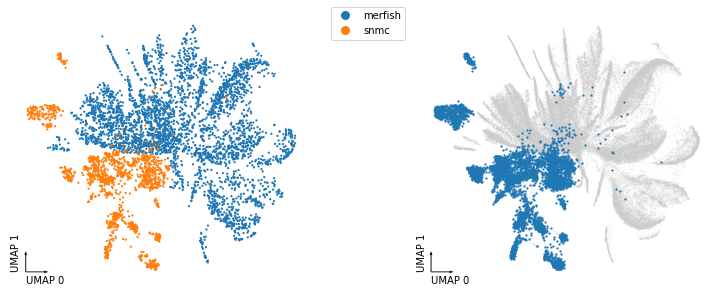

In [317]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
ax = axes[0]
_ = categorical_scatter(data=adata_merge.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='batch',
                        #text_anno='batch',
                        #palette='tab20',
                        labelsize=10,
                        show_legend=True)

ax = axes[1]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c=(0.8,0.8,0.8), s=1, alpha=0.3, edgecolor='none', rasterized=True)
tmp = adata_merge[adata_merge.obs['batch']=='snmc'].copy()
_ = categorical_scatter(data=tmp.obs,
                        ax=ax,
                        coord_base='umap',
                        #hue='Class',
                        #text_anno='CellTypeAnno',
                        palette='tab20',
                        labelsize=10,
                        show_legend=True
                       )             

# Run Harmony

In [318]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata_merge, 'batch', basis='X_pca', max_iter_harmony=30, random_state=0)

2021-12-30 18:10:37,924 - harmonypy - INFO - Iteration 1 of 30
INFO:harmonypy:Iteration 1 of 30
2021-12-30 18:16:25,405 - harmonypy - INFO - Iteration 2 of 30
INFO:harmonypy:Iteration 2 of 30
2021-12-30 18:21:41,520 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


In [319]:
adata_merge.write_h5ad('cell_244147_snmc_MERFISH.h5ad')

In [320]:
sc.pp.neighbors(adata_merge, n_neighbors=25, use_rep='X_pca_harmony')
sc.tl.umap(adata_merge)

In [321]:
adata_merge = dump_embedding(adata_merge, 'umap')

In [322]:
adata_merge.obsm['pc50hm_umap'] = adata_merge.obsm['X_umap'].copy()

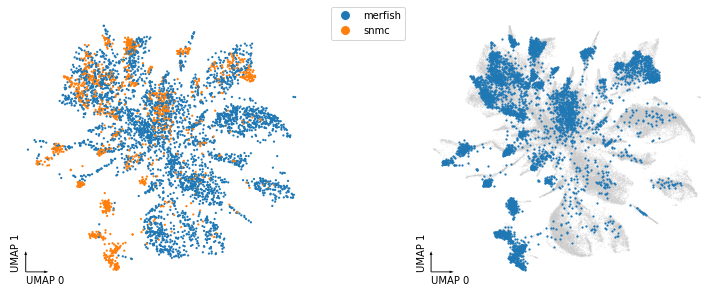

In [323]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)
ax = axes[0]
_ = categorical_scatter(data=adata_merge.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='batch',
                        #text_anno='batch',
                        #palette='tab20',
                        labelsize=10,
                        show_legend=True)

ax = axes[1]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c=(0.8,0.8,0.8), s=1, alpha=0.3, edgecolor='none', rasterized=True)
tmp = adata_merge[adata_merge.obs['batch']=='snmc'].copy()
_ = categorical_scatter(data=tmp.obs,
                        ax=ax,
                        coord_base='umap',
                        #hue='Class',
                        #text_anno='CellTypeAnno',
                        palette='tab20',
                        labelsize=10,
                        show_legend=True
                       )